In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras.layers import Dense, Dropout

In [26]:
#Import data and give column names
index_names = ['unit_no', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

train = pd.read_csv('../data/train_FD001.txt', sep='\s', header=None, names = col_names)
test = pd.read_csv('../data/test_FD001.txt', sep='\s', header=None, names = col_names)
y_test = pd.read_csv('../data/RUL_FD001.txt', sep='\s', header=None, names = ['RUL'])

c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
c:\users\flaarkol\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__m

,unit_no,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [3]:
# Function to add the corresponding RUL for each sample
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_no")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_no', right_index=True)
    
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [4]:
# Add RUL
train = add_remaining_useful_life(train)
train.head()

,unit_no,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [5]:
# Remove uninformative columns
drop_columns = ['setting_1', 'setting_2','setting_3', 's_1', 's_5', 's_10', 's_16', 's_18', 's_19']
keep_columns = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17','s_20','s_21']
x_train = train.copy()
y_train = x_train.pop('RUL')
x_test = test.copy()

In [6]:
scaler = MinMaxScaler()
scaler.fit(x_train[sensor_names])
x_train_scaled = x_train.copy()
x_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(x_train[sensor_names]), columns = sensor_names)

x_test_scaled = x_test.copy()
x_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(x_test[sensor_names]), columns = sensor_names)

x_train_scaled.head()

,unit_no,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [9]:
#Split training data into training and validation data
gss = GroupShuffleSplit(n_splits=1, train_size = 0.8, random_state = 42) 

def train_val_group_split(x, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(x, y, groups=groups):
        if print_groups:
            print('train_split_engines', x_train_scaled.iloc[idx_train]['unit_no'].unique(), '\n')
            print('validate_split_engines', x_train_scaled.iloc[idx_val]['unit_no'].unique(), '\n')

        X_train_split = x.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = x.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(x_train_scaled[keep_columns], y_train , gss, x_train_scaled['unit_no'])
x_train_split, y_train_split, x_val_split, y_val_split = split_result

print(x_train_split.shape)
print(y_train_split.shape)
print(x_val_split.shape)
print(y_val_split.shape)

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 

(16561, 15)
(16561,)
(4070, 15)
(4070,)


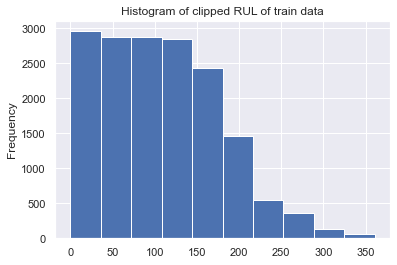

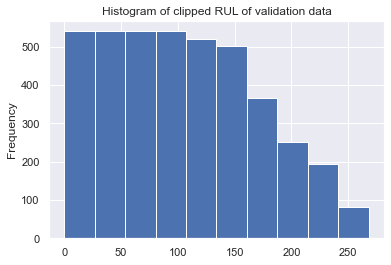

In [11]:
#Verify that training and validation data have the same distribution
plt.figure()
y_train_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of train data")
plt.show()
plt.close()

plt.figure()
y_val_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of validation data")
plt.show()


In [15]:
model = Sequential()
model.add(Dense(16, input_dim = x_train_split.shape[1], activation = 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
_________________________________________________________________


In [16]:
epochs = 20

history = model.fit(x_train_split, y_train_split, validation_data = (x_val_split, y_val_split), epochs = epochs)

Train on 16561 samples, validate on 4070 samples
Epoch 1/20
16561/16561 [==============================] - 1s 39us/step - loss: 5788.7177 - val_loss: 1552.0628
Epoch 2/20
16561/16561 [==============================] - 1s 40us/step - loss: 2140.3118 - val_loss: 1441.6761
Epoch 3/20
16561/16561 [==============================] - 1s 34us/step - loss: 2048.9256 - val_loss: 1386.4303
Epoch 4/20
16561/16561 [==============================] - 1s 34us/step - loss: 2007.7300 - val_loss: 1360.5799
Epoch 5/20
16561/16561 [==============================] - 1s 34us/step - loss: 1986.5529 - val_loss: 1330.0712
Epoch 6/20
16561/16561 [==============================] - 1s 34us/step - loss: 1975.3916 - val_loss: 1317.1889
Epoch 7/20
16561/16561 [==============================] - 1s 34us/step - loss: 1962.7298 - val_loss: 1305.0625
Epoch 8/20
16561/16561 [==============================] - 1s 36us/step - loss: 1948.1588 - val_loss: 1298.7709
Epoch 9/20
16561/16561 [==============================] - 1s 37

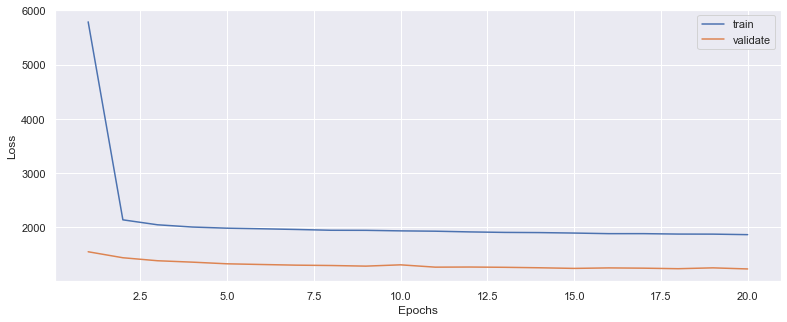

In [17]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [22]:
y_hat_train = model.predict(x_train_scaled[keep_columns])
model.evaluate(y_train, y_hat_train, 'train')

y_hat_test = model.predict(x_test_scaled)
model.evaluate(y_test, y_hat_test)

ValueError: Error when checking input: expected dense_4_input to have shape (15,) but got array with shape (1,)